# Full Training and Explanation Example

This notebook demonstrates MEGAN's complete workflow including multi-channel explanation extraction and visualization. Building on the basic usage example, this notebook focuses on MEGAN's unique explainability features and the systematic analysis of attention-based explanations.

## MEGAN's Multi-Channel Architecture in Practice

**Dual-Channel Regression**: For regression tasks, MEGAN employs two explanation channels that learn to identify molecular features contributing positively and negatively to the target property. This separation provides more nuanced explanations than single-attention mechanisms.

**Explanation Co-Training**: During training, MEGAN simultaneously optimizes prediction accuracy and explanation consistency through self-supervised learning, ensuring that attention weights capture genuine molecular relationships rather than spurious correlations.

**Attention-Based Interpretability**: Unlike post-hoc explanation methods, MEGAN's explanations are generated during the forward pass as an integral part of the prediction process, making them more reliable and computationally efficient.

# 🧪 Dataset Loading and Splitting

We'll prepare train and test datasets to evaluate MEGAN's performance and extract explanations from test samples.

In [10]:
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from rich.pretty import pprint

plt.style.use('default')


In [22]:
# --- loading the dataset ---
# Load the molecular dataset - same as basic example
PATH: str = os.getcwd()
DATASET_PATH: str = os.path.join(PATH, "clogp.csv")

dataset: pd.DataFrame = pd.read_csv(DATASET_PATH)

print('Dataset size:', len(dataset))
print('\nDataset preview:')
print(dataset.head())

# --- train-test split ---
# Create a reproducible train-test split for unbiased performance evaluation
random.seed(42)
np.random.seed(42)

# Split into 80% train, 20% test
indices = list(range(len(dataset)))
test_size = int(0.2 * len(dataset))
test_indices = random.sample(indices, k=test_size)
train_indices = [i for i in indices if i not in test_indices]

train_dataset = dataset.iloc[train_indices].copy()
test_dataset = dataset.iloc[test_indices].copy()

# Save split datasets for reproducibility and potential reuse
TRAIN_PATH = os.path.join(PATH, "train_clogp.csv")
TEST_PATH = os.path.join(PATH, "test_clogp.csv")

train_dataset.to_csv(TRAIN_PATH, index=False)
test_dataset.to_csv(TEST_PATH, index=False)

print(f'\nTrain set size: {len(train_dataset)}')
print(f'Test set size: {len(test_dataset)}')
print(f'Train set saved to: {TRAIN_PATH}')
print(f'Test set saved to: {TEST_PATH}')

Dataset size: 9887

Dataset preview:
                                    smiles    value
0                           Cc1cccc(C=C)c1  2.63802
1  Cc1cc(cc(C)c1O)C(C)(C)c2cc(C)c(O)c(C)c2  4.65738
2                    O=C1CCCCCCCCCOCCCCCO1  3.85090
3                   CCCCCCCCCCC(C)CCCCCCCC  7.90390
4                          NC(=O)N=NC(N)=O -0.40400

Train set size: 7910
Test set size: 1977
Train set saved to: /media/ssd/Programming/graph_attention_student/graph_attention_student/examples/train_clogp.csv
Test set saved to: /media/ssd/Programming/graph_attention_student/graph_attention_student/examples/test_clogp.csv


# ⚙️ Dataset Processing

We'll use the same MoleculeProcessing pipeline to ensure consistency with the basic example. This processing converts SMILES strings to graph dictionaries that MEGAN can process.

In [23]:
from visual_graph_datasets.processing.molecules import MoleculeProcessing

# Initialize the molecular processing pipeline - same as basic example
processing = MoleculeProcessing()

# Test the processing with a sample molecule to verify setup
SAMPLE_SMILES = 'C1=CC=C2C=C(CCN)C=CC2=C1'
sample_graph: dict = processing.process(SAMPLE_SMILES)

print('Graph attributes:')
pprint(list(sample_graph.keys()))
print(f'\nNumber of nodes: {len(sample_graph["node_attributes"])}')
print(f'Number of edges: {len(sample_graph["edge_attributes"])}')
print(f'Node features dimension: {processing.get_num_node_attributes()}')
print(f'Edge features dimension: {processing.get_num_edge_attributes()}')

Graph attributes:


[
│   'node_indices',
│   'node_attributes',
│   'edge_indices',
│   'edge_attributes',
│   'graph_attributes',
│   'graph_labels',
│   'graph_repr',
│   'node_atoms',
│   'edge_bonds'
]


Number of nodes: 13
Number of edges: 28
Node features dimension: 10
Edge features dimension: 4


# 🤖 MEGAN Model Configuration

Here we configure MEGAN with explanation capabilities enabled. The key parameters that distinguish MEGAN from standard GNNs are the explanation-related settings that enable the dual-channel attention mechanism and co-training objectives.

In [24]:
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader
from graph_attention_student import Megan, SmilesDataset

# --- MEGAN configuration for explainable predictions ---
model = Megan(
    # Input dimensions must match the MoleculeProcessing output
    node_dim=processing.get_num_node_attributes(),
    edge_dim=processing.get_num_edge_attributes(),
    
    # Graph encoder architecture - deeper networks can capture more complex patterns
    units=[64, 64, 64],  # Three message-passing layers for hierarchical feature learning
    final_units=[64, 32, 1],  # Prediction MLP: embedding -> intermediate -> single logP value
    
    # Task configuration for regression
    prediction_mode='regression',
    learning_rate=1e-4,
    
    # --- MEGAN's unique explanation configuration ---
    importance_mode='regression',  # Explanation channels tailored for continuous targets
    
    # KEY: importance_factor > 0 activates explanation co-training
    # This forces attention weights to be predictive of the target independently
    # Higher values prioritize explanation quality over pure prediction accuracy
    importance_factor=1.0,
    
    # Sparsity regularization prevents the model from highlighting everything as "important"
    # This promotes focused, interpretable explanations rather than diffuse attention
    sparsity_factor=0.5,
    
    # Controls the baseline attention level - affects explanation granularity
    # Higher values create more sparse (selective) explanations
    importance_offset=1.0,
    
    # For regression: 2 channels capture positive and negative evidence separately
    # This dual-channel approach provides more nuanced explanations than single attention
    num_channels=2,
)

print('MEGAN model configured with explanation capabilities:')
print(f'- Explanation channels: {model.num_channels}')
print(f'- Explanation co-training factor: {model.importance_factor}')
print(f'- Sparsity regularization factor: {model.sparsity_factor}')

MEGAN model configured with explanation capabilities:
- Explanation channels: 2
- Explanation co-training factor: 1.0
- Sparsity regularization factor: 0.5


In [25]:
# --- Training with SmilesDataset for efficient molecular data streaming ---
# SmilesDataset provides lazy loading and on-the-fly graph conversion
# This is memory-efficient for large molecular datasets
train_smiles_dataset = SmilesDataset(
    dataset=TRAIN_PATH,
    smiles_column='smiles',
    target_columns=['value'],
    processing=processing,  # Must use the same processing pipeline for consistency
    reservoir_sampling=True,  # Enables proper shuffling without loading entire dataset
)

# Configure DataLoader for batch processing
train_loader = DataLoader(
    train_smiles_dataset,
    batch_size=64,  # Balanced for stable gradients and memory efficiency
    drop_last=True,  # Prevents BatchNorm issues with variable-sized final batches
    num_workers=4,   # Parallel SMILES->graph conversion
    prefetch_factor=2,  # Pre-load batches to hide processing latency
)

# --- MEGAN training with multi-objective optimization ---
trainer = pl.Trainer(
    max_epochs=150,  # Extended training needed for explanation convergence
    accelerator='auto',
    devices='auto',
)

print('Starting MEGAN training with explanation co-training...')
print('Training objectives:')
print('1. Prediction accuracy (MSE loss)')
print('2. Explanation consistency (importance_factor * explanation_loss)')  
print('3. Attention sparsity (sparsity_factor * sparsity_loss)')

trainer.fit(model, train_dataloaders=train_loader)
model.eval()  # Critical: switch to evaluation mode for consistent inference
print('MEGAN training completed with explanation capabilities!')

/media/ssd/Programming/graph_attention_student/venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /media/ssd/Programming/graph_attention_student/venv/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type               | Params | Mode 
--------------------------------------------------------------------------
0  | lay_embedd                | Linear             | 704    | train
1  | lay_transform_1           | Linear             | 176    | train
2  | lay_transform_2           | Linear             | 16     | train
3  | encoder_layers            | ModuleList         | 607 K  | train
4  | lay_dropout_encoder       | Dropout            

Starting MEGAN training with explanation co-training...
Training objectives:
1. Prediction accuracy (MSE loss)
2. Explanation consistency (importance_factor * explanation_loss)
3. Attention sparsity (sparsity_factor * sparsity_loss)
Epoch 149: |          | 120/? [00:03<00:00, 30.38it/s, v_num=26, loss_pred=0.0997, loss_expl=0.432, loss_spar=0.314, loss_cont=0.000, loss_fid=0.000]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: |          | 120/? [00:04<00:00, 29.77it/s, v_num=26, loss_pred=0.0997, loss_expl=0.432, loss_spar=0.314, loss_cont=0.000, loss_fid=0.000]
MEGAN training completed with explanation capabilities!


# 📊 MEGAN Performance Evaluation

We evaluate the trained model on unseen test data to assess the prediction accuracy.

Evaluating MEGAN on training set...
Evaluating MEGAN on test set...

MEGAN Training Set Performance:
Samples: 7910 | RMSE: 0.3053 | MAE: 0.1979 | R²: 0.9838

MEGAN Test Set Performance:
Samples: 1977 | RMSE: 0.4611 | MAE: 0.2687 | R²: 0.9615


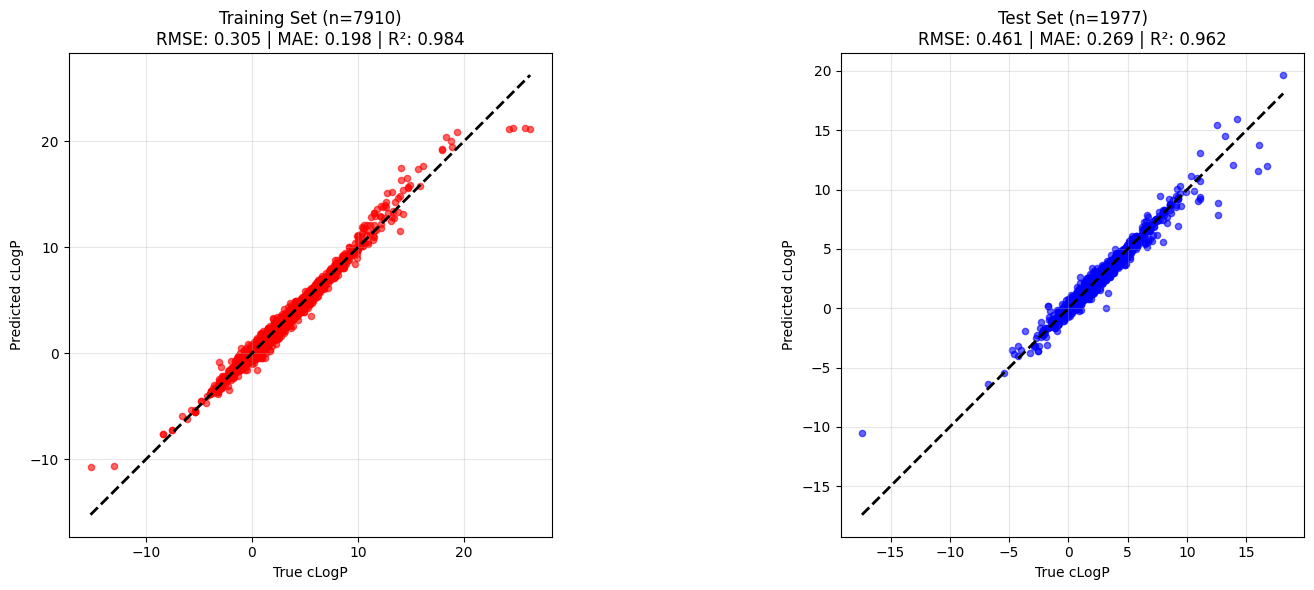

In [26]:
# --- Evaluate MEGAN on both training and test sets ---
# This compares performance on seen vs unseen data to assess overfitting
train_predictions = []
train_targets = []

print('Evaluating MEGAN on training set...')
for idx, row in train_dataset.iterrows():
    smiles = row['smiles']
    target = row['value']
    
    try:
        graph = processing.process(smiles)
        result = model.forward_graph(graph)
        prediction = result['graph_output'].item()
        
        train_predictions.append(prediction)
        train_targets.append(target)
        
    except Exception as e:
        print(f'Skipping molecule {smiles}: {e}')
        continue

train_predictions = np.array(train_predictions)
train_targets = np.array(train_targets)

# Evaluate on test set
test_predictions = []
test_targets = []
test_smiles_list = []

print('Evaluating MEGAN on test set...')
for idx, row in test_dataset.iterrows():
    smiles = row['smiles']
    target = row['value']
    
    try:
        graph = processing.process(smiles)
        result = model.forward_graph(graph)
        prediction = result['graph_output'].item()
        
        test_predictions.append(prediction)
        test_targets.append(target)
        test_smiles_list.append(smiles)
        
    except Exception as e:
        print(f'Skipping molecule {smiles}: {e}')
        continue

test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

# Calculate metrics for both sets
train_mse = mean_squared_error(train_targets, train_predictions)
train_mae = mean_absolute_error(train_targets, train_predictions)
train_r2 = r2_score(train_targets, train_predictions)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(test_targets, test_predictions)
test_mae = mean_absolute_error(test_targets, test_predictions)
test_r2 = r2_score(test_targets, test_predictions)
test_rmse = np.sqrt(test_mse)

print(f'\nMEGAN Training Set Performance:')
print(f'Samples: {len(train_predictions)} | RMSE: {train_rmse:.4f} | MAE: {train_mae:.4f} | R²: {train_r2:.4f}')

print(f'\nMEGAN Test Set Performance:')
print(f'Samples: {len(test_predictions)} | RMSE: {test_rmse:.4f} | MAE: {test_mae:.4f} | R²: {test_r2:.4f}')

# Create side-by-side regression plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Training set plot (red)
ax1.scatter(train_targets, train_predictions, alpha=0.6, color='red', s=20)
train_range = [train_targets.min(), train_targets.max()]
ax1.plot(train_range, train_range, 'k--', lw=2)
ax1.set_xlabel('True cLogP')
ax1.set_ylabel('Predicted cLogP')
ax1.set_title(f'Training Set (n={len(train_predictions)})\nRMSE: {train_rmse:.3f} | MAE: {train_mae:.3f} | R²: {train_r2:.3f}')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal', adjustable='box')

# Test set plot (blue)
ax2.scatter(test_targets, test_predictions, alpha=0.6, color='blue', s=20)
test_range = [test_targets.min(), test_targets.max()]
ax2.plot(test_range, test_range, 'k--', lw=2)
ax2.set_xlabel('True cLogP')
ax2.set_ylabel('Predicted cLogP')
ax2.set_title(f'Test Set (n={len(test_predictions)})\nRMSE: {test_rmse:.3f} | MAE: {test_mae:.3f} | R²: {test_r2:.3f}')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# 🔍 Extracting MEGAN's Multi-Channel Explanations

Now we demonstrate how to extract and interpret MEGAN's dual-channel attention mechanisms. Unlike standard GNNs, MEGAN provides separate importance scores for positive and negative evidence, enabling more detailed analysis of model reasoning.

In [27]:
# Select representative examples for explanation analysis
np.random.seed(42)
explanation_indices = np.random.choice(len(test_smiles_list), size=10, replace=False)

print(f'Selected {len(explanation_indices)} examples for MEGAN explanation analysis:')
for i, idx in enumerate(explanation_indices):
    smiles = test_smiles_list[idx]
    target = test_targets[idx]
    prediction = test_predictions[idx]
    print(f'{i+1}. SMILES: {smiles[:50]}... | True: {target:.3f} | Pred: {prediction:.3f}')

Selected 10 examples for MEGAN explanation analysis:
1. SMILES: O=S1(=O)OC2(C3=C(C=CC(O)=C3)OC3=C2C=C(O)C=C3)C2=C1... | True: 3.214 | Pred: 3.951
2. SMILES: COC1COC2C(COC12)OC... | True: -0.186 | Pred: 0.330
3. SMILES: c1cc(C)ccc1C... | True: 2.303 | Pred: 2.489
4. SMILES: CC(=O)OC3CCC4C2CCC1=CC(=O)CCC1(C)C2CCC34C ... | True: 4.450 | Pred: 4.211
5. SMILES: O=C1CNC(=O)C2=C(C=CC(Cl)=C2)N1... | True: 1.022 | Pred: 1.138
6. SMILES: CC(C)CC(C)OC(C)=O... | True: 1.984 | Pred: 1.870
7. SMILES: Cc1cccc(CO)c1... | True: 1.487 | Pred: 1.498
8. SMILES: CCC[C@H]1CCCCN1... | True: 1.929 | Pred: 2.397
9. SMILES: CC=CCC1(C)C(=O)NC(=O)N(C)C1=O... | True: 0.667 | Pred: 0.312
10. SMILES: CCOC(=O)CN(C)C(=O)COC(=O)C1=CC=CC=C1OC(C)=O... | True: 0.790 | Pred: 0.663


In [28]:
# Function to normalize MEGAN's importance values for consistent visualization
def normalize_importances(importances):
    """
    Normalize MEGAN importance values to [0, 1] range for consistent visualization.
    This ensures that attention weights are comparable across different molecules
    and channels, enabling meaningful visual comparisons.
    """
    min_val = np.min(importances)
    max_val = np.max(importances)
    if max_val > min_val:
        return (importances - min_val) / (max_val - min_val)
    else:
        return np.zeros_like(importances)

# Extract MEGAN's dual-channel explanations for selected molecules
explanation_results = []

print('Extracting MEGAN explanations...')
for idx in explanation_indices:
    smiles = test_smiles_list[idx]
    target = test_targets[idx]
    prediction = test_predictions[idx]
    
    # Process molecule and extract full MEGAN output including attention weights
    graph = processing.process(smiles)
    result = model.forward_graph(graph)
    
    # MEGAN's key outputs:
    # - node_importance: (num_nodes, num_channels) - attention weights for each atom
    # - edge_importance: (num_edges, num_channels) - attention weights for each bond
    node_importance = result['node_importance']
    edge_importance = result['edge_importance']
    
    # Normalize for consistent visualization across molecules
    node_importance_norm = normalize_importances(node_importance)
    edge_importance_norm = normalize_importances(edge_importance)
    
    explanation_results.append({
        'smiles': smiles,
        'target': target,
        'prediction': prediction,
        'graph': graph,
        'node_importance': node_importance_norm,  # Shape: (num_atoms, 2) for dual channels
        'edge_importance': edge_importance_norm,  # Shape: (num_bonds, 2) for dual channels
    })

print(f'Extracted MEGAN explanations for {len(explanation_results)} molecules.')
print(f'Each explanation has {explanation_results[0]["node_importance"].shape[1]} attention channels.')
print('Channel 0: Features contributing negatively to logP (hydrophilic)')  
print('Channel 1: Features contributing positively to logP (hydrophobic)')

Extracting MEGAN explanations...
Extracted MEGAN explanations for 10 molecules.
Each explanation has 2 attention channels.
Channel 0: Features contributing negatively to logP (hydrophilic)
Channel 1: Features contributing positively to logP (hydrophobic)


# 🎨 Visualizing MEGAN's Dual-Channel Explanations

MEGAN's visualization system overlays attention-based importance maps onto molecular structures. The dual-channel approach separates positive and negative evidence, providing clearer interpretation of model reasoning than single-channel attention mechanisms.

Creating MEGAN explanation visualizations...


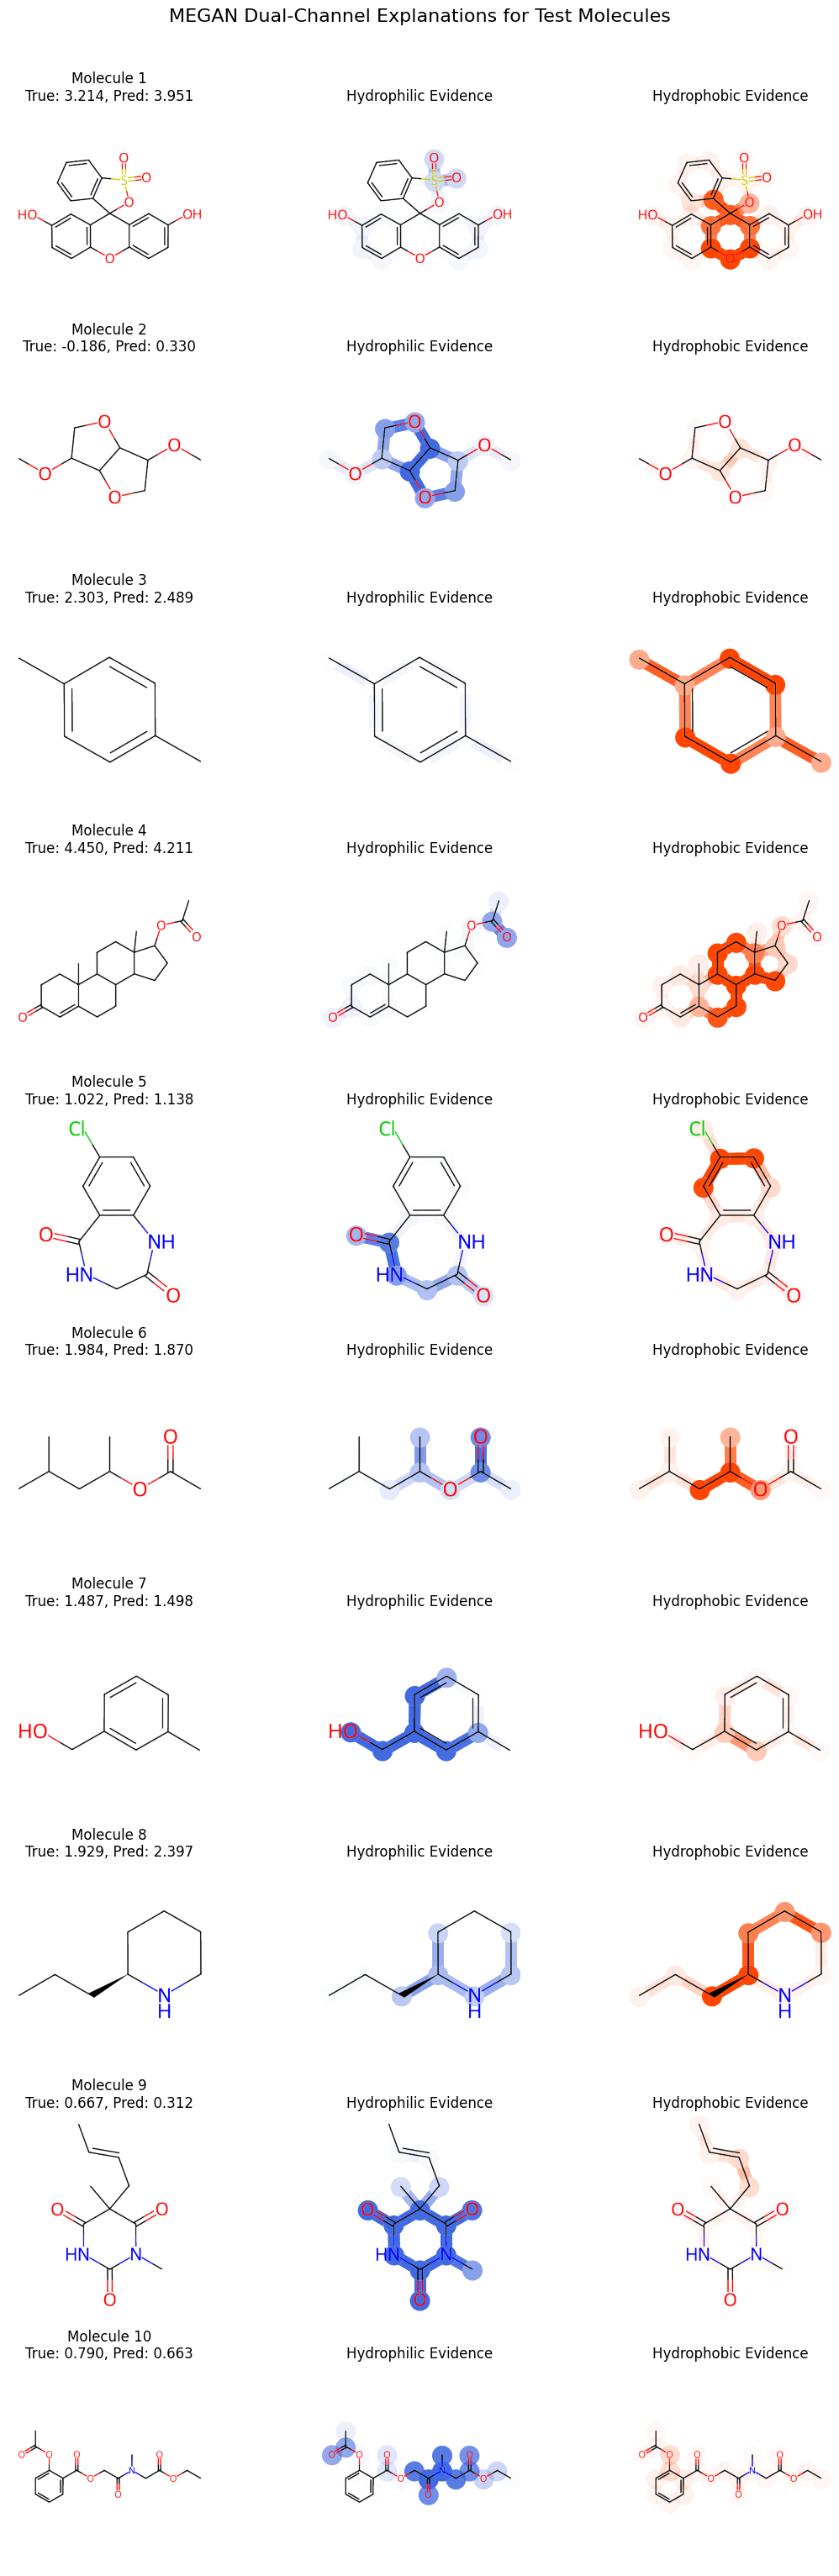


Explanation Guide:
• Blue highlights: Molecular features that decrease logP (increase hydrophilicity)
• Red highlights: Molecular features that increase logP (increase hydrophobicity)
• Intensity indicates the strength of contribution according to MEGAN attention weights
• Both atoms (circles) and bonds (lines) can contribute to the final prediction


In [29]:
from visual_graph_datasets.visualization.importances import plot_node_importances_background
from visual_graph_datasets.visualization.importances import plot_edge_importances_background
from visual_graph_datasets.visualization.base import draw_image
import tempfile

# Create comprehensive visualization showing MEGAN's dual-channel explanations
num_examples = len(explanation_results)
num_channels = 2  # MEGAN's dual channels for regression
fig_width = 4 * (num_channels + 1)  # Original molecule + 2 explanation channels
fig_height = 3 * num_examples

fig, axes = plt.subplots(
    nrows=num_examples, 
    ncols=num_channels + 1,  # Molecular structure + dual explanation channels
    figsize=(fig_width, fig_height)
)

# Ensure axes is always 2D for consistent indexing
if num_examples == 1:
    axes = axes.reshape(1, -1)

# Color scheme for MEGAN's dual channels
channel_colors = ['royalblue', 'orangered']  # Blue for negative, red for positive  
channel_labels = ['Hydrophilic Evidence', 'Hydrophobic Evidence']

print('Creating MEGAN explanation visualizations...')
for row, result in enumerate(explanation_results):
    smiles = result['smiles']
    target = result['target']
    prediction = result['prediction']
    graph = result['graph']
    node_importance = result['node_importance']
    edge_importance = result['edge_importance']
    
    # Generate molecular structure visualization using MoleculeProcessing
    mol_fig, node_positions = processing.visualize_as_figure(smiles, width=400, height=400)
    # Coordinate transformation for matplotlib compatibility
    node_positions[:, 1] = 400 - node_positions[:, 1]  # Invert y-axis for proper overlay alignment
    
    # Save molecular visualization for overlay operations
    temp_file = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
    mol_fig.savefig(temp_file.name)
    temp_file.close()
    
    # Store node positions in graph dict for visualization functions
    graph['node_positions'] = node_positions
    
    # Column 0: Original molecular structure
    ax_orig = axes[row, 0]
    ax_orig.imshow(np.array(mol_fig.canvas.renderer.buffer_rgba()))
    ax_orig.set_title(f'Molecule {row+1}\nTrue: {target:.3f}, Pred: {prediction:.3f}')
    ax_orig.axis('off')
    
    # Columns 1-2: MEGAN's dual explanation channels
    for channel in range(num_channels):
        ax = axes[row, channel + 1]
        
        # Draw base molecular structure
        ax.imshow(np.array(mol_fig.canvas.renderer.buffer_rgba()))
        
        # Overlay MEGAN's node importance (atomic contributions)
        # Higher intensity = greater importance in this channel
        plot_node_importances_background(
            ax=ax,
            g=graph,
            node_positions=node_positions,
            node_importances=node_importance[:, channel],
            color=channel_colors[channel],
            radius=20,  # Size of importance circles around atoms
            v_min=0,
            v_max=1,
        )
        
        # Overlay MEGAN's edge importance (bond contributions) 
        # Line thickness/opacity indicates bond importance
        plot_edge_importances_background(
            ax=ax,
            g=graph,
            node_positions=node_positions,
            edge_importances=edge_importance[:, channel],
            color=channel_colors[channel],
            thickness=10,  # Width of importance lines over bonds
            v_min=0,
            v_max=1,
        )
        
        ax.set_title(f'{channel_labels[channel]}')
        ax.axis('off')
    
    plt.close(mol_fig)  # Clean up temporary figure

plt.tight_layout()
plt.suptitle('MEGAN Dual-Channel Explanations for Test Molecules', y=1.02, fontsize=16)
plt.show()

print('\nExplanation Guide:')
print('• Blue highlights: Molecular features that decrease logP (increase hydrophilicity)')
print('• Red highlights: Molecular features that increase logP (increase hydrophobicity)')
print('• Intensity indicates the strength of contribution according to MEGAN attention weights')
print('• Both atoms (circles) and bonds (lines) can contribute to the final prediction')